# STAARS climatology example

|  |  |
| ----------- | ----------- |
| Author:| Laurent Besnard |
| Edited:| Benjamin Stepin |
| Affiliation:| IMOS |
| e-mail:| info@aodn.org.au |
| Date of creation:| 4th Jul., 2019 |
| Date of last update:| 24th Jun., 2024 |



## Table of Contents
### [Background](#background)
### [Required  Packages](#required-python-packages)

1. [Accessing and Opening using S3](#1-accessing-and-opening-the-s3-file)
2. [Downloading from S3](#2-downloading-the-netcdf-from-s3-bucket)
3. [Open downloaded file](#3-opening-the-local-file-with-xarray)
4. [Extracting arrays from the Dataset](#4-extracting-arrays-from-the-ds-dataset-for-the-region-of-interest)

### Background

The Sea Surface Temperature Atlas of the Australian Regional Seas ([SSTAARS](https://portal.aodn.org.au/search?uuid=79c8eea2-4e86-4553-8237-4728e27abe10)) covers the seasonal variability and trends around Australasia by making use of 25 years of Advanced Very High Resolution Radiometer (AVHRR) data from NOAA Polar Orbiting Environmental Satellites, received by six Australian and two Antarctic reception stations, to construct a detailed climatology of sea surface temperature (SST) at 20 cm depth around Australasia.

#### Data processing - technical detail

The data have been processed following international GHRSST protocols to help reduce instrument bias using in situ data, with only night-time nearly cloud-free data used to reduce diurnal bias and cloud contamination. A pixel-wise climatology (with four annual sinusoids) and linear trend are fit to the data using a robust technique and monthly non-seasonal percentiles derived. The resulting atlas has a spatial resolution of ~2km and thus reveals unprecedented detail of regional oceanographic phenomena, including-

- tidally-driven entrainment cooling over shelves and reef flats,
- wind-driven upwelling,
- shelf winter water fronts,
- cold river plumes,
- the footprint of the seasonal boundary currrent flows, and
- standing mesoscale features in the major offshore currents.

The atlas (and associated statistics) will provide a benchmark for high-resolution ocean modellers and be a resource for ecosystem studies where temperatures, and their extremes, impact on ocean chemistry, species ranges and distribution.

### Required Python Packages

- xarray
- dask
- s3fs
- tempfile

In [1]:
# Use this code to install packages
# !pip install xarray dask s3fs tempfile

## Visualisation of SSTAARS climatology accessed through AODN S3 repository

### Three ways to access AODN data:
* [AODN portal](https://portal.aodn.org.au/)
* [THREDDS server](http://thredds.aodn.org.au/thredds/catalog.html)
   * [SSTAARS example](http://thredds.aodn.org.au/thredds/catalog/CSIRO/Climatology/SSTAARS/2017/AODN-product/catalog.html)
   * OPENDAP: /thredds/__dodsC__/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_001.nc
   * HTTPServer: /thredds/__fileServer__/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_001.nc
* Amazon Web Services (AWS) s3 bucket - object oriented repository:  
   * [Explore s3 bucket](https://data.aodn.org.au)
   * S3 bucket name: imos-data
   * [Download from AWS s3 server](https://help.aodn.org.au/downloading-data-from-servers/amazon-s3-servers/)
   * Accessing/ Downloading using python s3fs library (this notebook)


### Accessing without downloading:
In python, you can access the AODN files using OPENDAP or s3fs library.  The s3 bucket is the AODN original depository. To provide DAP access to the file, AODN developed some functions to retrieve (and cache) data files from S3. It is more direct to access the data through S3 directly. 

### 1. Accessing and opening the s3 file


In [2]:
#libraries
import xarray as xar
import matplotlib.pyplot as plt
import dask
import s3fs
import tempfile

import warnings
warnings.filterwarnings('ignore')

#s3 FileSystem 
s3 = s3fs.S3FileSystem(anon = True)

# imos bucket on AWS is named 'imos-data'
# list directories using s3.ls
s3.ls('imos-data') # imos bucket name

# list directories and files using 
s3.ls('imos-data/CSIRO/Climatology/SSTAARS/2017')

['imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product',
 'imos-data/CSIRO/Climatology/SSTAARS/2017/SSTAARS.nc']

In [3]:
# original product SSTRAARS.nc (with harmonics) and AODN-product with daily fit already calculated
# SSTAARS climatology : listing directories and daily files
s3.ls('imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product')[0:10]

['imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit.nc',
 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_001.nc',
 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_002.nc',
 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_003.nc',
 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_004.nc',
 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_005.nc',
 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_006.nc',
 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_007.nc',
 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_008.nc',
 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_009.nc']

In [4]:
# Opening a daily climatology from AODN-product:
# # 28th of January is day 28
# we can directly open a netcdf file using the s3 location
file = 'imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit_028.nc'

# But unfortunatly the following does not work because of an attribute read error with NetCDF4 files, 
# so we will download the file locally
# ds = xar.open_mfdataset(file)

### 2. Downloading the netcdf from s3 bucket


In [5]:

temp_file = tempfile.mkstemp()
temp_file_path = temp_file[1]

# download command : s3.get (s3_file, local_file)
s3.get(file, temp_file_path)

[None]

### 3. Opening the local file with xarray

In [6]:
# opening the local file with xarray as a dataset
# we need option decode_times=False because this is a climatology with no calendar date associated with it
ds = xar.open_dataset(temp_file_path, decode_times=False)

# exploring the xarray dataset
ds

<xarray.Dataset> Size: 648MB
Dimensions:              (DAY_OF_YEAR: 1, LATITUDE: 4500, LONGITUDE: 6000)
Coordinates:
  * DAY_OF_YEAR          (DAY_OF_YEAR) int16 2B 28
  * LATITUDE             (LATITUDE) float32 18kB -69.99 -69.97 ... 19.97 19.99
  * LONGITUDE            (LONGITUDE) float32 24kB 70.01 70.03 ... 190.0 190.0
    DEPTH                float32 4B ...
Data variables:
    TEMP                 (DAY_OF_YEAR, LATITUDE, LONGITUDE) float32 108MB ...
    TEMP_std_err         (DAY_OF_YEAR, LATITUDE, LONGITUDE) float32 108MB ...
    TEMP_mean            (LATITUDE, LONGITUDE) float32 108MB ...
    TEMP_mean_std_err    (LATITUDE, LONGITUDE) float32 108MB ...
    TEMP_change          (LATITUDE, LONGITUDE) float32 108MB ...
    TEMP_change_std_err  (LATITUDE, LONGITUDE) float32 108MB ...
Attributes: (12/33)
    abstract:                      25 years of Advanced Very High-Resolution ...
    acknowledgement:               The User agrees that whenever the Product ...
    author:                        Galibert, Guillaume
    author_email:                  guillaume.galibert@utas.edu.au
    citation:                      The citation in a list of references is: "...
    Conventions:                   CF-1.6,IMOS-1.4
    ...                            ...
    source:                        One-day composites of night-only sea surfa...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_step:            1.0
    title:                         SST Atlas of Australian Regional Seas (SST...
    time_coverage_end:             2017-01-28T00:00:00Z
    time_coverage_start:           2017-01-28T00:00:00Z

### 4. Extracting arrays from the ds dataset for the region of interest:

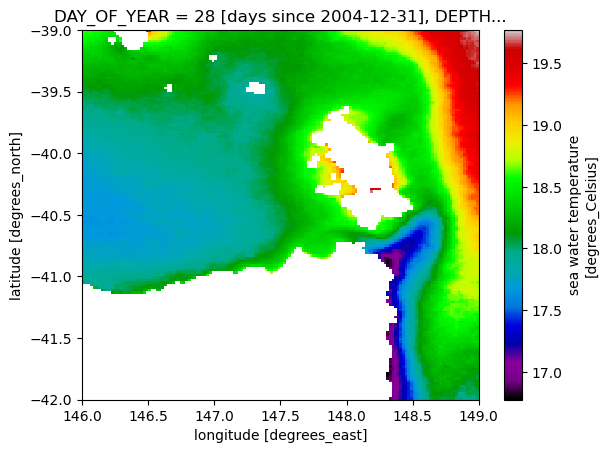

In [7]:
## Coordinates values found from WFS [147.88, -40] 
port_davies_lat_min = -42.0
port_davies_lat_max = -39.0
port_davies_lon_min = 146
port_davies_lon_max = 149

colormap='nipy_spectral'
cmap = plt.get_cmap(colormap) 

ds.TEMP.sel(LATITUDE=slice(port_davies_lat_min, port_davies_lat_max), 
            LONGITUDE=slice(port_davies_lon_min, port_davies_lon_max)).plot(cmap=cmap)